- [introduction](#introduction)
- [assumptions](#assumptions)
- [methodology](#methodology)
- [implementation](#implementation)
  - [data](#data)
  - [results](#results)
- [appendix](#appendix)
  - [walkthrough: non-parametric](#walkthrough-non-parametric)

# introduction
On February 24th 04:06 UTC+1, the "special military operation" was announced by the Russian president and the Russian army invaded Ukraine. In the run-up to the event, there had been warnings by US officials about the possibility of this outcome. Was the invasion expected by the FX market &mdash; a known barometer of a country's economic well-being? Did the warnings reinforce the expectation?

To answer these questions, I take note that the annonuncement was followed by a depreciation of RUB to the level of about 85 RUB per 1 USD; i assume that the market participants had anticipated this development in the case of an invasion, and use currency options to estimate its probability.

I find that the probability of an invasion was not higher than 5-10% in the week before it was officially announced and jumped to 25% in the hours immediately before.

<img src="./output/figures/prob-nonparam-thresh85.png" alt="probability of invasion getting higher on feb 23rd" width="600"/>

# assumptions
In the immediate run-up to the invasion (a week or so):
1. the FX market participants expected RUB to fall to the level of 85 RUB per 1 USD in case of an invasion;
1. USDRUB dynamics was strongly determined by expectations of an invasion and by little else;
2. changes in the risk-neutral probability coincided with changes in the physical probability (risk premium was constant);
3. the risk-neutral distribution did not have tails that could not be approximated by those of a spherical distribution;
4. markets were sufficiently liquid, and Bloomberg quotes &mdash; representative.

While assumptions 1-3 are alright: the time span of a week is short and the conflict was arguably the major driver of related asset prices &mdash; assumption 3 is already prohibitively strong and compromises the very idea of estimating the probability of a tail risk event; assumption 4 is strong, but not too strong.

# methodology

To estimate the probability of the spot rate exceeding a certain threshold, I integrate the option-implied density of the spot rate extracted non-parametrically over a suitable domain.

The well-known result from [Breeden and Litzenberger (1978)](https://www.jstor.org/stable/2352653?seq=1#metadata_info_tab_contents) equates the risk-neutral density of the underlying $q(S)$ to the second derivative of the option pricing function $C(\cdot)$ w.r.t. the strike price $K$:
$$q(S) = e^{r_f \tau} \frac{\partial^2 C(S,K,\ldots)}{\partial K^2}.$$
With a pricing function at hand, numerical calculation of the density is straighforward. Here, I take $C$ to be the Black-Scholes pricing function at the level of spline-interpolated implied volatilities along the strike dimension:
$$C(S, K), \ldots = C^{bs}(S, \hat{\sigma}(K), K, \ldots),$$
where $\hat{\sigma}(K)$ is the spline interpolator fitted to the observed pairs of ($K, \sigma$).

# implementation

## imports

In [1]:
# pip/conda
import pandas as pd
import numpy as np
from tensorflow_probability import distributions as tfd  # mixture distribution
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.dates import DateFormatter, DayLocator, HourLocator  # plotting
from tqdm.notebook import tqdm  # keep track of progress in loops
import warnings  # suppress warnings
from functools import reduce

# local
from optools.blackscholes import option_price as bs_price
from optools.rnd import fit_lognormal_mix

# project
from src.setup import *
from src.datafeed_.downstream import *
from src.visuals import *
from src.recipes import estimate_probability

## settings

In [2]:
# parameters
TAU = 1/12  # maturity of options

# matplotlib
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']

# frames
def format_dataframe(df_: pd.DataFrame, tail=True):
    """A little formatter helper."""
    if tail:
        return format_dataframe(df_.tail(), tail=False)
    if df_.columns.nlevels > 1:
        col_key = ("date", "")
    else:
        col_key = "date"
    res_ = df_.reset_index()\
        .style.format(formatter={col_key: lambda x: x.strftime("%Y-%m-%d %H:%M")},
                      precision=2)\
        .hide(axis=0)
    return res_

# suppress warnings
warnings.filterwarnings('ignore')

## data

### events

Events and their timestamps (GMT+1) are from Bloomberg.

In [17]:
# load events data
d_events = get_timeline()
dt_t = d_events.index[0]

format_dataframe(d_events, tail=False)

date,event
2022-02-24 04:06,putin announces special military operation
2022-02-18 22:58,biden warns russia planning attack in coming days
2022-02-17 15:19,biden estimate prob of invasion as very high
2022-02-11 20:03,jake sullivan believes putin has decided to invade next week
2022-02-11 11:34,blinken warns russia can attack during the olympics


### spot
Spot quotes of USDRUB at 1-min frequency (GMT+1 time) are from Bloomberg.

In [4]:
# load spot data
d_spot = get_spot_data()

format_dataframe(d_spot.set_index("date"), tail=True)

date,spot
2022-02-28 16:46,109.50
2022-02-28 16:47,109.61
2022-02-28 16:48,109.54
2022-02-28 16:49,107.90
2022-02-28 16:50,107.82


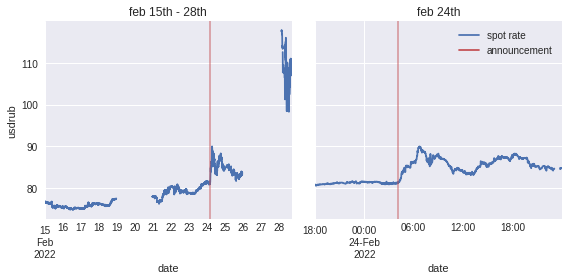

In [7]:
# plot spot exchange rate dynamics
plot_spot(d_spot.set_index("date").squeeze())
plt.show()

### forward
1-month forward quotes are from Bloomberg:

In [8]:
# load forward data
d_forward = get_forward_data()

format_dataframe(d_forward, tail=True)

index,date,forward
46325,2022-02-28 16:46,112.64
46326,2022-02-28 16:47,112.75
46327,2022-02-28 16:48,112.69
46328,2022-02-28 16:49,111.01
46329,2022-02-28 16:50,110.92


### rates
USD rates are 1-month OIS rates; RUB rates are implied from the covered interest rate parity for USDRUB:
$$ F = S \times \frac{1 + r_{rub}}{1 + r_{usd}} $$

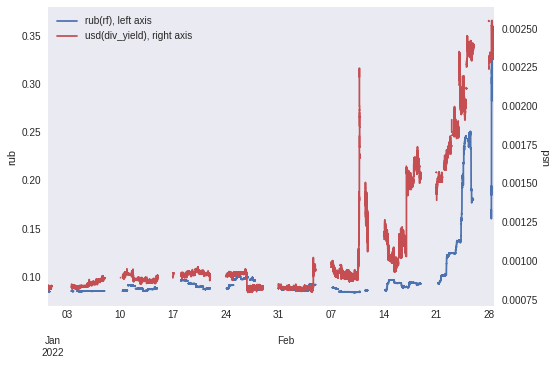

In [30]:
# interest rates data: 'rf' for the RUB rate, 'div_yield' for the USD rate.
d_rates = get_rates_data()
plot_rates(d_rates.set_index("date"))
plt.show()

### option iv quotes

Options data is in the form of strikes and corresponding Black-Scholes implied volatilities for each date.

In [16]:
# options data
d_opt = get_option_data()

format_dataframe(d_opt.sort_values("date"), tail=True)

index,strike,date,vol
5800,182.59,2022-02-28 16:44,1.23
17402,83.90,2022-02-28 16:44,0.79
23203,84.27,2022-02-28 16:44,0.77
11601,136.68,2022-02-28 16:44,1.00
30109,109.07,2022-02-28 16:44,0.85


## estimating probability of invasion
I present only the results of the calculations here. A detailed walkthrough is postponed to [the appendix](#walkthrough-non-parametric).

In [42]:
# non-parametric density, integrated from different levels upwards
prob_np = pd.read_csv("output/estimates/prob-nonparam.csv", index_col=0, parse_dates=True)\
    .rename(columns=int)

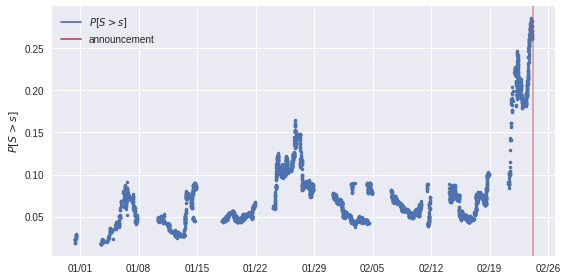

In [43]:
thresh = 85
fig = plot_invasion_probability(prob_np.loc[:dt_t, thresh], show_invasion=True)
plt.show()

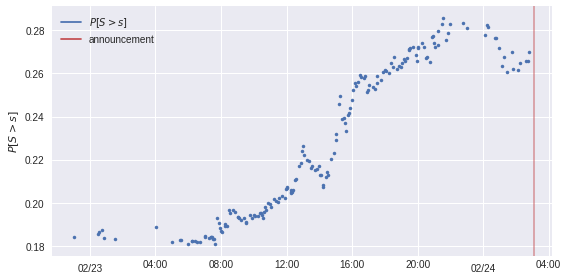

In [37]:
plot_invasion_probability_zoomed(prob_np.loc[:, thresh])
plt.show()

The probability of invasion is thus estimated at a level of 5-10% in the week leading to Putin's announcement, suddenly jumping to 25% in the day before it and remaining at that level until the news were broken.

At other levels of the threshold the probabilities adjust accordingly:

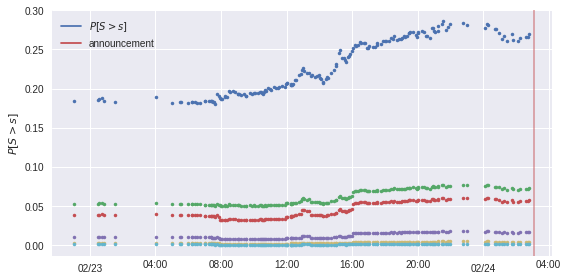

In [39]:
plot_invasion_probability_zoomed(prob_np)
plt.show()

Next, I check how this probability changed in response to the forebodings of US officials. In total, there were 4 of them, as listed in the [data section](#events).

# appendix

## walkthrough: non-parametric <a name="walkthrough-non-parametric"></a>

In what follows I will walk an interested reader through the calculations. First, let's load the data, merge everything and select one datetime &mdash; the one right before the announcement.

In [20]:
# data
d_option = get_option_data()
d_forward = get_forward_data()
d_rates = get_rates_data()
timeline = get_timeline()

# drop dates with <5 observations
n_per_date = d_option.groupby("date").count().iloc[:, 0]
good_dt = n_per_date.loc[n_per_date.gt(4)].index
d_option = d_option.loc[d_option["date"].isin(good_dt)]

# merge all the necessary data (produces duplicates for some vars)
data = reduce(
    lambda x_, y_: pd.merge(x_, y_, on="date", how="inner"),
    [d_option, d_forward, d_rates]
)
data = data.sort_values("date")

# select one little chunk
dt = timeline.index[0]
data = data.query("date < @dt").tail(5)

format_dataframe(data)

index,strike,date,vola,forward,div_yield,rf
26690,101.93,2022-02-24 03:48,0.57,82.16,0.00,0.14
26691,89.44,2022-02-24 03:48,0.43,82.16,0.00,0.14
26692,75.42,2022-02-24 03:48,0.31,82.16,0.00,0.14
26693,70.22,2022-02-24 03:48,0.30,82.16,0.00,0.14
26694,81.72,2022-02-24 03:48,0.36,82.16,0.00,0.14


These are the values observed at `dt` and sufficient to estimate the risk-neutral density. For that, as mentioned in the main part, the option pricing function is needed. I define it to be, for any strike $K$, the Black-Scholes formula evaluated at the fitted implied volatility at that level of $K$; the volatility itself is a function of $K$, specifically, the fitted value of a cubic spline calibrated to the observed values of ($K, \sigma$) in the data chunk above: 
$$C(S, K), \ldots = C^{bs}(S, \hat{\sigma}(K), K, \ldots).$$
One thing to note is that the span of strike prices is usually very narrow and far from covering the whole range of non-trivial densities: in the case above it's from 70.22 to 101.93. Hence, extrapolation beyound the min and max values is inevitable; as advised in many papers (e.g. [Jiang and Tian (2005)](https://www.jstor.org/stable/3598022)), I keep the IV constant at the fringe of the strike range. The interpolated IV smile would look like something this:

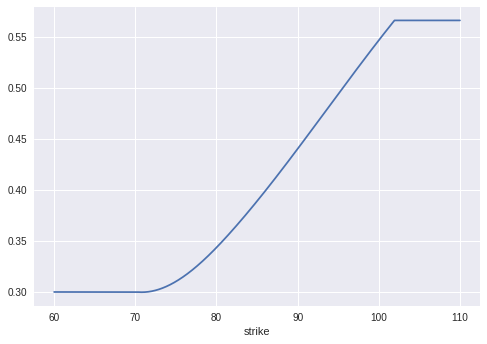

In [22]:
from optools.volsmile import VolatilitySmile

VolatilitySmile(data[["strike", "vola"]].set_index("strike").squeeze(), tau=TAU)\
    .interpolate(kind="cubic", new_x=np.arange(60, 110, 1e-02), extrapolate=True)\
    .plot()
plt.show()

With that in mind, let's define the interpolator function $\hat{\sigma}(K)$ above as follows:

In [23]:
from scipy.interpolate import interp1d

# implied volatility interpolator
def iv_interpolator() -> callable:
    """Get function to interpolate Black-Scholes IV at a given strike.
    
    NB: Takes the global variable `data` defined above as input!
    """
    k_iv = data[["strike", "vola"]].sort_values("strike", ascending=True)
    
    # min, max for extrapolation at constant values
    min_v = k_iv.iloc[0].loc["vola"]
    max_v = k_iv.iloc[-1].loc["vola"]

    # if extrapolation is w/constant values
    f = interp1d(x=k_iv["strike"].values, 
                 y=k_iv["vola"].values, 
                 kind="cubic",
                 assume_sorted=True,
                 bounds_error=False,
                 fill_value=(min_v, max_v))
    
    return f

# example
sigma_hat = iv_interpolator()
print(sigma_hat(np.array([100, 110.0, 120.0])))

[0.54668989 0.5661     0.5661    ]


Now, it is possible to define the option pricing function $C^{bs}(S, \hat{\sigma}(K), K, \ldots)$ as a function of $K$ only:

In [24]:
from optools.blackscholes import option_price as bs_price

sigma_hat = iv_interpolator()  # enters the function below

def call_pricer(x_):
    """Get price of call option at a given strike.
    
    NB: takes global variable `data` defined above as input!
    """
    rf = data["rf"].iloc[0]
    
    # these are the same for any iloc in `data`
    forward = data["forward"].iloc[0]
    div_yield = data["div_yield"].iloc[0]
    rf = data["rf"].iloc[0]
    
    f = bs_price(strike=x_, vola=sigma_hat(x_), forward=forward,
                 div_yield=div_yield, rf=rf,
                 tau=TAU, is_call=True)
    
    return f

# example
print(call_pricer(np.array([100, 110.0, 120.0])))

[0.721248   0.22674576 0.05555404]


This function can be differentiated twice to arrive at the density. Below, I define a function to return the density at point `s`:

In [25]:
from scipy.misc import derivative

def density_estimator(s):
    """Get density at point `s`.
    
    Evaluates the second-order derivative of `call_pricer`.
    
    NB: takes global variables `call_pricer` and `data` defined above as input!
    
    """
    res = derivative(call_pricer, s, dx=1e-04, n=2) \
        * np.exp(data["rf"].iloc[0] * TAU)
    
    return res

# example
print(density_estimator(100.0))

0.003882754513015593


Finally, to arrive at the probability of the spot rate exceeding a threshold, e.g. 85, at options' expiration, I integrate the density from this threshold to ~infinity~ a large value:

In [26]:
from scipy.integrate import simps

# domain of integration (step size of 1e-04)
thresh = 85.0
x = np.arange(thresh, 200, 1e-04)

# integrate
prob = simps(density_estimator(x), x)
print(prob)

0.27008469930723195


## robustness checks
### parametric density
Another approach is to fit a parametric density to the observed option prices, and a popular choice is the mixture of 2 log-normal curves (e.g. [Söderlind and Svensson (1997)](https://www.nber.org/system/files/working_papers/w5877/w5877.pdf)). For each date, I take the five available strike prices and corresponding Black-Scholes volatilities, compute the option prices and fit the mixture of 2 log-normal distributions by minimizing the weighted sum of squared errors:
$$ \min_{\theta} \left\Vert C(K, F, \sigma, y | \theta) - c \right\Vert^2, $$
where $C(\cdot | \theta)$ is the option pricing function parametrized by $\theta$ and $c$ are the observed option quotes. As the sixth data point, I use the forward, for which a closed-form solution in the two log-normals setting also exists.

Below I estimate the parameters and the probability of USDRUB reaching 85 for a subset of data (~1000 observations in February)

In [ ]:
# data, setting datetime index where necessary
data_option = get_option_data()
data_forward = get_forward_data()
data_rates = get_rates_data()

# merge all the necessary data (produces duplicates for some vars)
data = reduce(
    lambda x_, y_: pd.merge(x_, y_, on="date", how="inner"),
    [data_option, data_forward, data_rates]
)

# take ~1000 observations in early Feb for demo purposes
data = data\
    .loc[data["date"].dt.month == 2]\
    .sort_values("date")\
    .head(1000)

# fit mixture
theta = dict()
prob = dict()
for dt, dt_grp in tqdm(data.groupby("date")):
    
    f_ = dt_grp["forward"].iloc[0]
    r_ = dt_grp[["rf", "div_yield"]].iloc[0]
    k_, v_ = dt_grp["strike"].values, dt_grp["vola"].values

    # compute option prices first
    c_price = bs_price(
        strike=k_, vol=v_, forward=f_,
        rf=r_["rf"], div_yield=r_["div_yield"],
        is_call=True, tau=1/12
    )

    # initial values
    x0_ = np.array(
        [0.34] + [np.log(f_) - v_.mean() ** 2 / 2] * 2 + [v_.mean()] * 2
    )

    # fit!
    theta_ = fit_lognormal_mix(
        option_price=c_price, strike=k_, is_call=True,
        forward=f_, rf=r_["rf"],
        x0=x0_, weights=np.array([2, 1, 1, 1, 1, 1])
    )
    
    # use fitted parameters to compute the rnd
    rnd = tfd.Mixture(
        cat=tfd.Categorical(probs=[theta_[0], 1. - theta_[0]]),
        components=[
            tfd.LogNormal(loc=theta_[1], scale=theta_[3]),
            tfd.LogNormal(loc=theta_[2], scale=theta_[4]),
        ]
    )

    prob_ = 1 - rnd.cdf(85).numpy()
    
    theta[dt] = theta_
    prob[dt] = prob_

# to pandas objects
theta = pd.DataFrame\
    .from_dict(theta, orient="index",
               columns=["w", "mu1", "mu2", "sigma1", "sigma2"])\
    .rename_axis(index="date")
prob = pd.Series(prob)

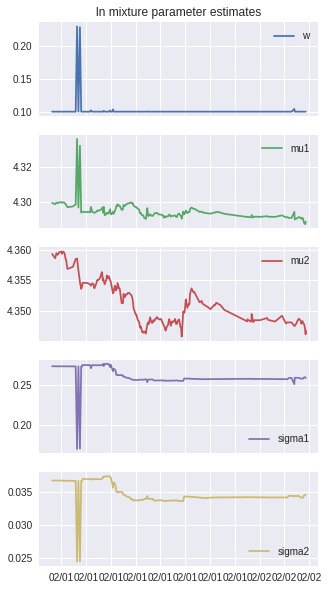

In [4]:
# take a look at the estimated parameters
fig, ax = plt.subplots(5, 1, figsize=(5, 10), sharex=True)

theta.plot(ax=ax, subplots=True)

for ax_ in ax[:-1]:
    ax_.set_xticklabels([])
    ax_.set_xlabel("", visible=False)

ax[-1].set_xlabel("", visible=False)
ax[-1].xaxis.set_major_formatter(DateFormatter("%m/%d"))
ax[0].set_title("ln mixture parameter estimates")

plt.show()

Let's plot the estimated probability

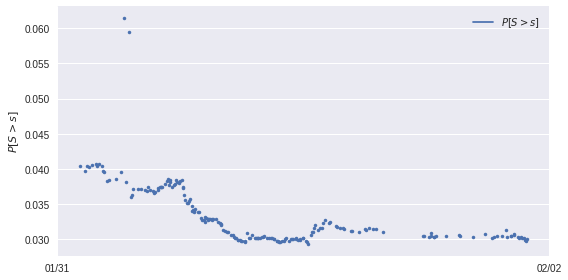

In [5]:
fig = plot_invasion_probability(prob, show_invasion=False)
plt.show()

The following is the slighly quicker (parallelized) function to estimate the same as above for the full sample

In [3]:
# data, setting datetime index where necessary
data_option = get_option_data()
data_forward = get_forward_data()
data_rates = get_rates_data()
dt_t = get_timeline().index[0]  # invasion announcement

prob_par = estimate_probability(data_option, data_forward, data_rates,
                                kind="parametric", parallelize=True)

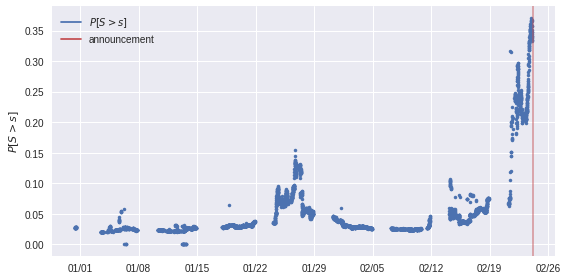

In [4]:
# plot again, the full sample
fig = plot_invasion_probability(prob_par.loc[:dt_t], show_invasion=True)
plt.show()

Let's zoom in on February 23-24th...

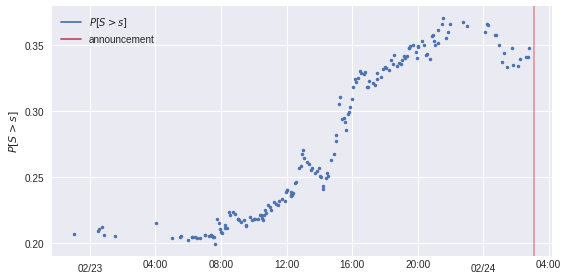

In [4]:
fig = plot_invasion_probability_zoomed(prob_par)
plt.show()